In [1]:
from scipy.io import arff
from scipy.spatial.distance import cdist
from matplotlib import dates
from sklearn.neighbors import LocalOutlierFactor # not used
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import struct

In [50]:
def k_mean(K, dataset, title="K-Mean Cluster Plot",):
    k_model = KMeans(n_clusters=K)
    k_model.fit(dataset)
    y_pred = k_model.predict(dataset)
    centroids = k_model.cluster_centers_
    
    %matplotlib notebook
    plt.figure(figsize=(12,12))
    plt.scatter(dataset.iloc[:,0], dataset.iloc[:,1], marker='o', alpha=1, c=y_pred)
    plt.scatter(centroids[:,0],centroids[:,1], marker='x', s = 200, linewidths=2)
    plt.xlabel(dataset.columns.values[0])
    plt.ylabel(dataset.columns.values[1])
    plt.title(title)
    plt.show()

In [43]:
def k_nn(dataset, target, label, title="K-Near Neighbor"):
    df = dataset.drop([label], axis=1)
    var = preprocessing.LabelEncoder()
    labelEncoder = var.fit_transform(dataset[label])
    model = KNeighborsClassifier(n_neighbors = 3)
    knn = KNeighborsClassifier(n_neighbors = 5)
    
    model.fit(dataset[[target]], labelEncoder)
    predicted = model.predict([[0]])
    xTrain, xTest, yTrain, yTest = train_test_split(df, dataset[label], test_size = 0.3, random_state=42)
    knn.fit(xTrain, yTrain)
    yPred = knn.predict(xTest)
    return yPred

In [4]:
def swarm_all(dataset, X):
    df = dataset.drop([X], axis=1)
    for i in df.columns:
        sns.swarmplot(x=X, y=i, data=dataset)
        plt.show()

In [5]:
def violin_all(dataset, X):
    df = dataset.drop([X], axis=1)
    for i in df.columns:
        sns.violinplot(x=X, y=i, data=dataset)
        plt.show()

In [45]:
def find_k_graph(kTests, data, title="Selecting K with the Elbow Method"):
    # k-means cluster analysis
    clusters=range(1,kTests+1)
    meandist=[]
    
    for k in clusters:
        model=KMeans(n_clusters=k)
        model.fit(data)
        clusassign=model.predict(data)
        meandist.append(sum(np.min(cdist(data, model.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0])
    # Identify number of clusters
    %matplotlib inline
    plt.plot(clusters, meandist)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average distance')
    plt.title(title)
    plt.show()

# NSL-KDD Dataset

<u>Load NSL-KDD dataset</u>

In [40]:
kddFile = arff.loadarff('KDDTrain+.arff')
kddDF = pd.DataFrame(kddFile[0])
kddDF = kddDF.assign(Class=kddDF['class'].apply(lambda x: x.decode('utf-8')))
kddDF = kddDF.drop(['class'], axis=1)
kddDF = kddDF.assign(logged_in=kddDF['logged_in'].apply(lambda x: float(x.decode('utf-8'))))
kddDF.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Class
0,0.0,b'tcp',b'ftp_data',b'SF',491.0,0.0,b'0',0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0.0,b'udp',b'other',b'SF',146.0,0.0,b'0',0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0.0,b'tcp',b'private',b'S0',0.0,0.0,b'0',0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0.0,b'tcp',b'http',b'SF',232.0,8153.0,b'0',0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0.0,b'tcp',b'http',b'SF',199.0,420.0,b'0',0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [8]:
kddDF.describe()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.022687,0.000111,0.204409,0.001222,0.279250,0.001342,0.001103,...,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.253530,0.014366,2.149968,0.045239,23.942042,0.036603,0.045154,...,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,3.000000,3.000000,77.000000,5.000000,7479.000000,1.000000,2.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<u> Finding K </u>

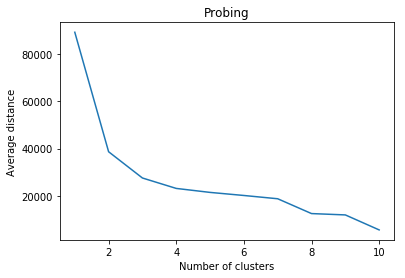

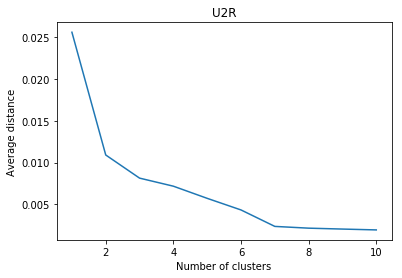

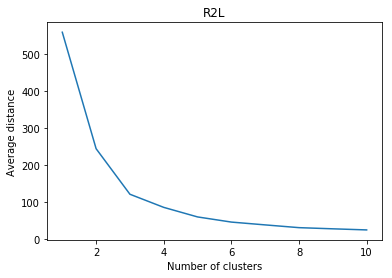

In [52]:
find_k_graph(10, kddDF[['duration','src_bytes']], "Probing")
find_k_graph(10, kddDF[['num_file_creations', 'num_shells']], "U2R")
find_k_graph(10, kddDF[['duration', 'num_failed_logins']], "R2L")

<IPython.core.display.Javascript object>


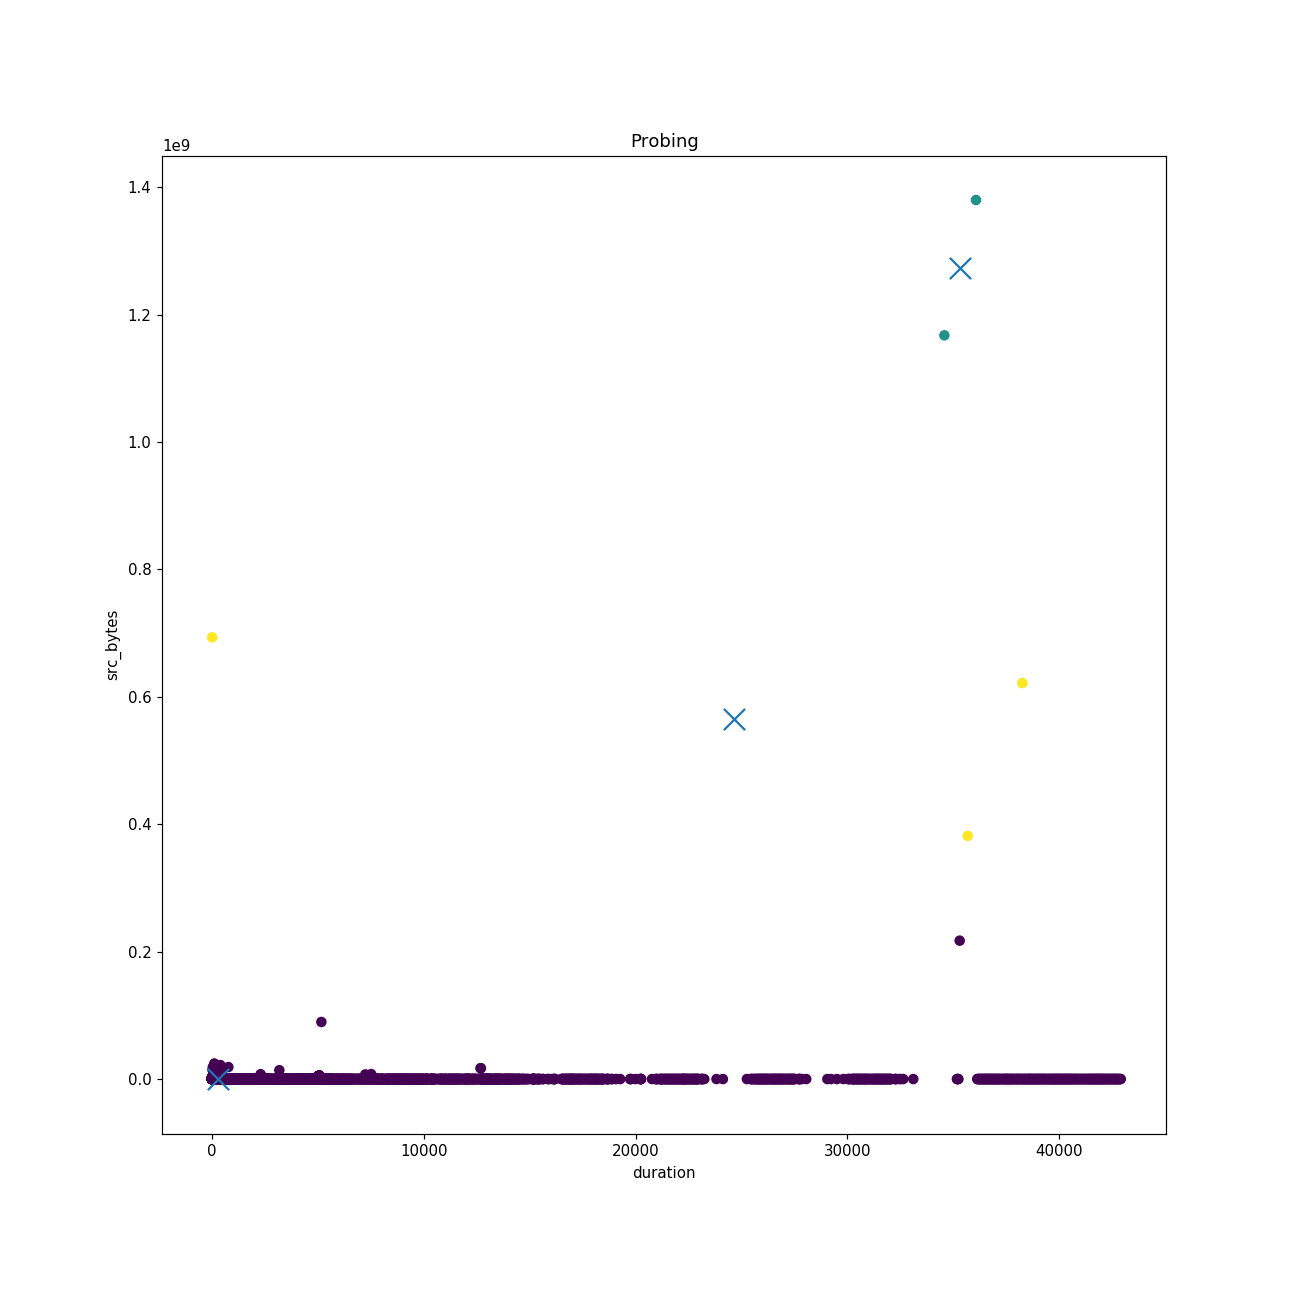

In [55]:
k_mean(3, kddDF[["duration","src_bytes"]], "Probing")

<IPython.core.display.Javascript object>


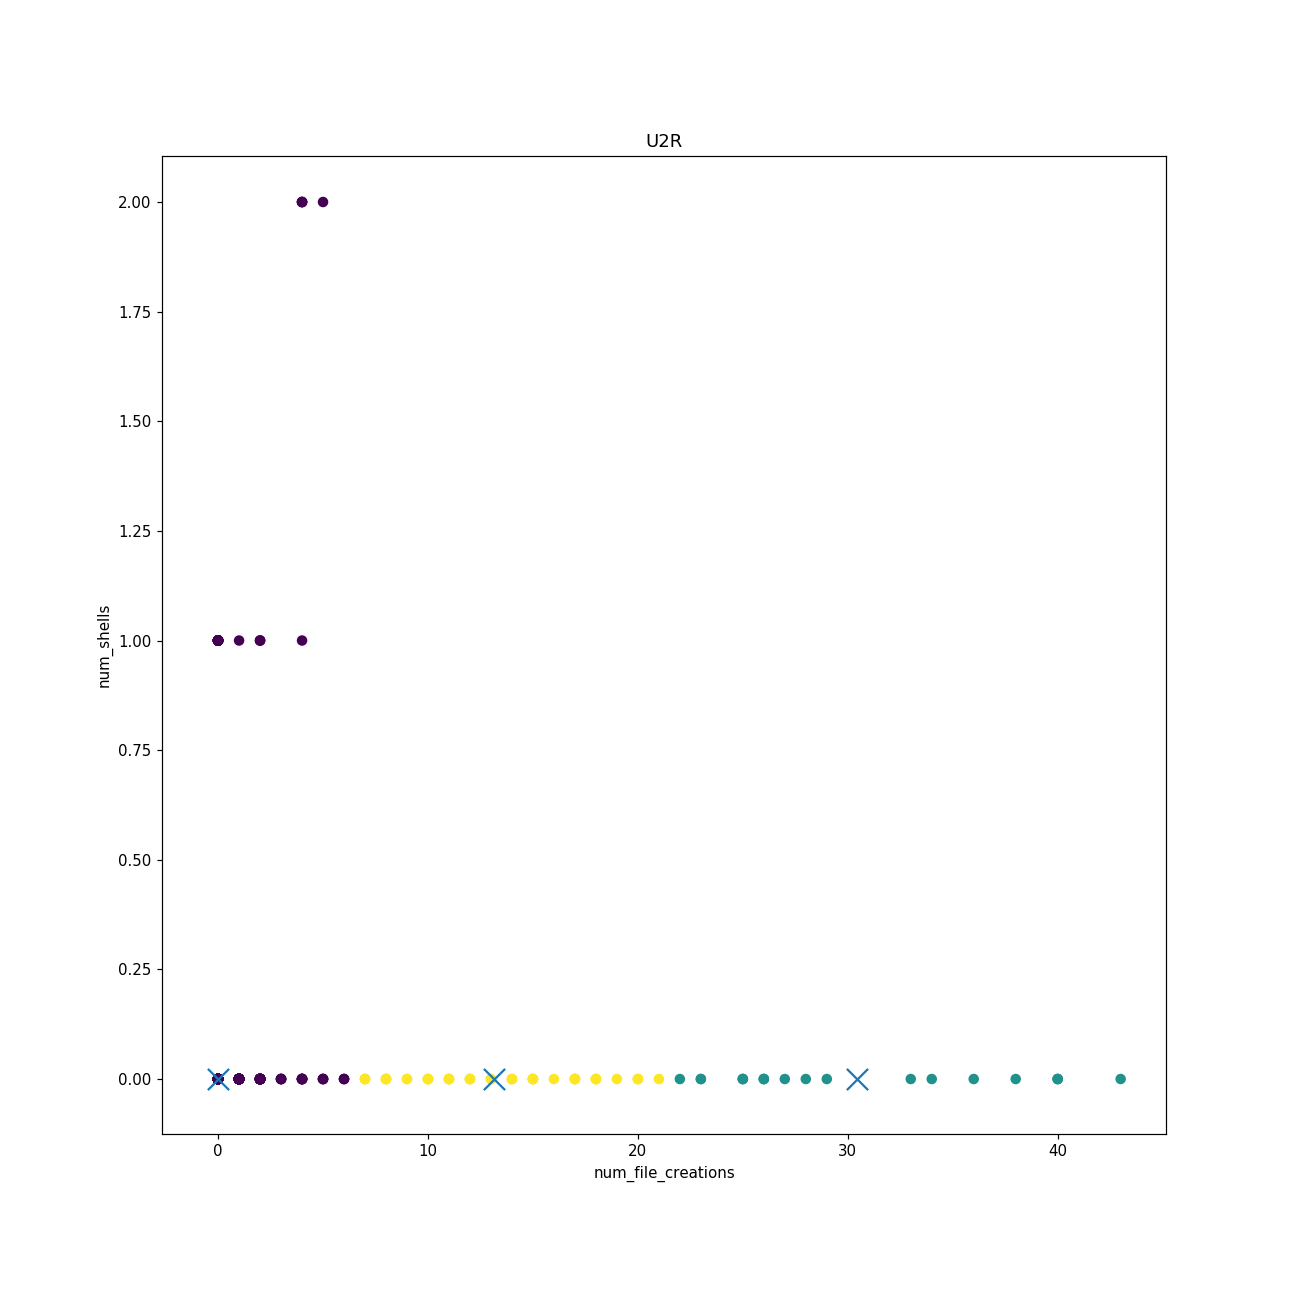

In [56]:
k_mean(3, kddDF[['num_file_creations', 'num_shells']], "U2R")

<IPython.core.display.Javascript object>


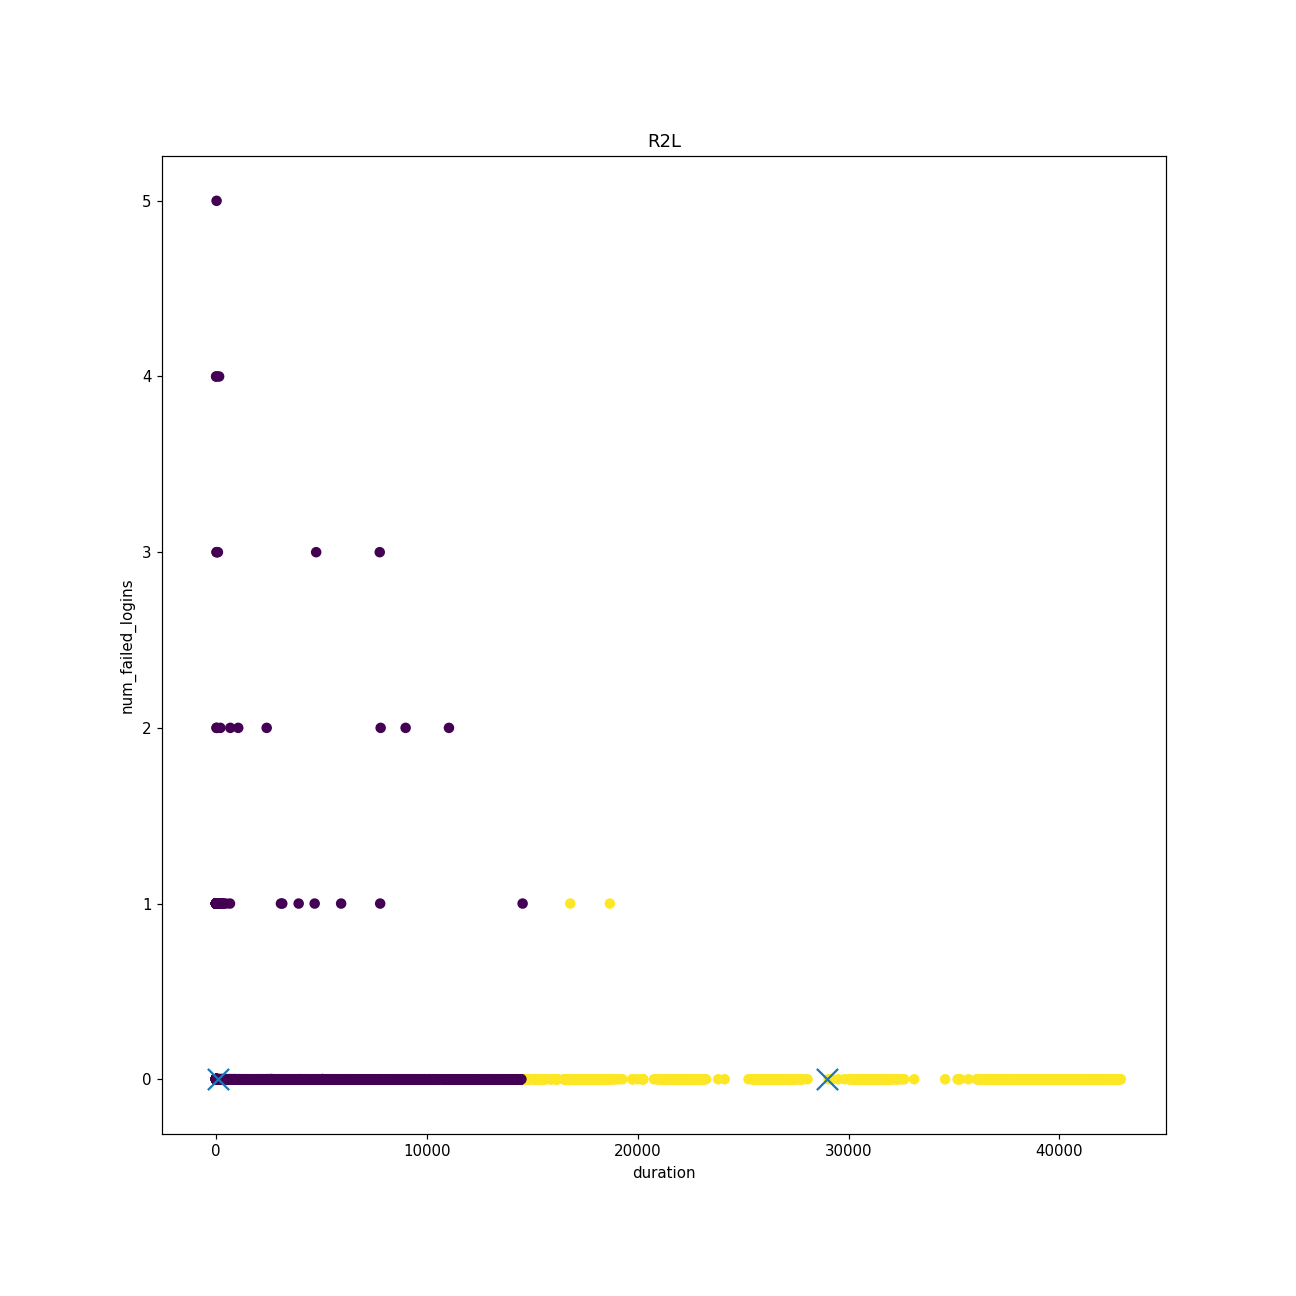

In [57]:
k_mean(2, kddDF[['duration', 'num_failed_logins']], "R2L")

In [59]:
knn = k_nn(kddDF[['duration', 'Class', 'src_bytes']], "duration", "Class", "K-Near Neighbor on NSL-KDD Dataset")
print("done")

done


In [60]:
for i in knn:
    print(i)

normal
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
anomaly
normal
anomaly
normal
anomaly
normal
normal
normal
normal
normal
normal
normal
normal
normal
anomaly
normal
normal
normal
anomaly
anomaly
normal
normal
normal
anomaly
normal
normal
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
normal
normal
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
normal
anomaly
normal
normal
normal
anomaly
anomaly
normal
normal
anomaly
normal
normal
normal
normal
normal
normal
anomaly
normal
normal
normal
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
anomaly
normal
normal
anomaly
normal
normal
normal
normal
anomaly
anomaly
normal
anomaly
anomaly
normal
normal
normal
normal
normal
anomaly
anomaly
anomaly
normal
anomaly
normal
anomaly
normal
normal
anomaly
normal
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
anomaly
normal
normal
normal
normal
normal
anomaly
normal
normal
anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
normal
anomaly
normal

anomaly
normal
normal
anomaly
normal
normal
anomaly
anomaly
anomaly
anomaly
anomaly
normal
anomaly
normal
normal
normal
anomaly
normal
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
normal
normal
anomaly
anomaly
anomaly
normal
anomaly
anomaly
normal
normal
normal
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
normal
normal
normal
anomaly
anomaly
normal
anomaly
anomaly
anomaly
normal
anomaly
anomaly
anomaly
anomaly
normal
anomaly
normal
normal
normal
anomaly
normal
normal
anomaly
normal
normal
anomaly
anomaly
normal
normal
normal
anomaly
anomaly
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
normal
anomaly
normal
normal
normal
anomaly
anomaly
anomaly
anomaly
normal
anomaly
normal
normal
normal
normal
anomaly
normal
normal
normal
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
normal
normal
anomaly
a

normal
normal
anomaly
normal
normal
normal
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
normal
normal
normal
normal
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
anomaly
normal
normal
normal
normal
anomaly
anomaly
normal
anomaly
anomaly
anomaly
normal
anomaly
normal
anomaly
normal
normal
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
normal
normal
normal
normal
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
anomaly
anomaly
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
normal
normal
normal
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
normal
normal
anomaly
anomaly
anomaly
anomaly
normal
normal
anomaly
anomaly
anomaly
normal
anomaly
normal
normal
anomaly
anomaly
normal
normal
normal
normal
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
normal

anomaly
normal
normal
anomaly
normal
normal
normal
normal
anomaly
normal
normal
normal
anomaly
normal
normal
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
normal
normal
anomaly
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
normal
anomaly
normal
normal
anomaly
normal
normal
anomaly
anomaly
normal
anomaly
anomaly
anomaly
normal
anomaly
normal
normal
normal
anomaly
anomaly
anomaly
normal
normal
normal
anomaly
anomaly
anomaly
normal
normal
normal
normal
anomaly
anomaly
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
normal
normal
anomaly
normal
normal
anomaly
normal
normal
anomaly
anomaly
normal
normal
normal
anomaly
anomaly
anomaly
anomaly
normal
normal
anomaly
normal
normal
normal
normal
normal
anomaly
anomaly
normal
normal
normal
normal
normal
normal
normal
normal


normal
anomaly
normal
anomaly
normal
normal
anomaly
anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
normal
normal
normal
normal
normal
normal
normal
anomaly
anomaly
anomaly
normal
anomaly
anomaly
normal
anomaly
anomaly
anomaly
normal
anomaly
anomaly
anomaly
normal
anomaly
anomaly
anomaly
anomaly
normal
normal
normal
normal
anomaly
anomaly
anomaly
normal
anomaly
anomaly
anomaly
normal
normal
normal
anomaly
normal
normal
normal
anomaly
anomaly
anomaly
anomaly
anomaly
normal
normal
normal
normal
normal
anomaly
normal
anomaly
normal
normal
normal
anomaly
normal
normal
normal
normal
anomaly
anomaly
normal
anomaly
anomaly
anomaly
anomaly
normal
normal
normal
normal
normal
normal
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
anomaly
anomaly
normal
anomaly
normal
normal
normal
normal
normal
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
normal
anomaly
normal
anomaly
normal
anomaly
anomaly
anomaly
normal
a

normal
anomaly
normal
normal
normal
normal
normal
anomaly
normal
anomaly
normal
normal
normal
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
normal
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
anomaly
normal
anomaly
normal
normal
normal
normal
normal
anomaly
normal
normal
anomaly
anomaly
anomaly
anomaly
normal
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
normal
normal
anomaly
normal
normal
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
normal
anomaly
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
normal
anomaly
normal
anomaly
anomaly
anomaly
normal
normal
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
anomaly
normal
normal
anomaly
normal
anomaly
anomaly
anomaly
normal
anomaly
normal
a

normal
anomaly
normal
normal
anomaly
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
normal
anomaly
normal
normal
normal
anomaly
normal
normal
normal
normal
normal
normal
normal
normal
normal
anomaly
anomaly
normal
normal
normal
anomaly
normal
normal
anomaly
normal
normal
anomaly
normal
anomaly
anomaly
anomaly
normal
normal
anomaly
normal
normal
anomaly
anomaly
normal
normal
normal
normal
normal
anomaly
anomaly
anomaly
anomaly
normal
normal
normal
normal
anomaly
anomaly
normal
anomaly
anomaly
anomaly
normal
normal
normal
anomaly
anomaly
anomaly
anomaly
anomaly
normal
normal
normal
normal
normal
anomaly
normal
anomaly
normal
anomaly
normal
anomaly
normal
normal
normal
anomaly
normal
normal
normal
normal
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
normal
normal
anomaly
anomaly
normal
normal
normal
anomaly
anomaly
anomaly
normal
normal
normal
anomaly
normal
normal
anomaly
normal
normal
anomaly
normal
normal
anomaly
normal
n

anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
anomaly
normal
normal
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
anomaly
normal
normal
normal
anomaly
anomaly
anomaly
normal
anomaly
normal
normal
anomaly
anomaly
normal
normal
normal
anomaly
anomaly
anomaly
normal
normal
anomaly
normal
normal
anomaly
normal
anomaly
normal
normal
normal
anomaly
anomaly
anomaly
anomaly
normal
anomaly
normal
anomaly
normal
normal
normal
anomaly
normal
normal
normal
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
anomaly
anomaly
normal
normal
normal
normal
anomaly
normal
normal
normal
normal
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
anomaly
anomaly
normal
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
normal
anomaly
normal

anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
normal
normal
normal
anomaly
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
normal
normal
normal
anomaly
anomaly
normal
normal
anomaly
normal
normal
normal
anomaly
normal
normal
anomaly
normal
normal
normal
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
anomaly
normal
anomaly
normal
normal
normal
normal
normal
normal
normal
anomaly
normal
normal
anomaly
normal
anomaly
normal
normal
normal
normal
anomaly
normal
normal
anomaly
anomaly
anomaly
anomaly
anomaly
normal
anomaly
normal
normal
normal
normal
anomaly
normal
anomaly
anomaly
anomaly
normal
normal
anomaly
normal
normal
normal
normal
normal
anomaly
anomaly
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
anomaly
normal
anomaly
normal
normal
normal
normal
normal
anomaly
anomaly
normal
normal
normal
normal
normal
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
anomaly
normal
anomaly
normal
normal
anomaly
anomaly
normal
anomaly
anomaly
normal
normal
norma

normal
normal
normal
anomaly
anomaly
normal
normal
anomaly
normal
anomaly
normal
anomaly
anomaly
anomaly
normal
normal
anomaly
anomaly
anomaly
normal
normal
anomaly
anomaly
anomaly
normal
normal
normal
normal
anomaly
anomaly
anomaly
normal
normal
anomaly
anomaly
anomaly
normal
normal
anomaly
normal
normal
normal
anomaly
anomaly
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
anomaly
anomaly
normal
anomaly
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
normal
normal
anomaly
normal
normal
anomaly
anomaly
normal
normal
normal
anomaly
normal
normal
anomaly
anomaly
normal
anomaly
normal
normal
normal
anomaly
normal
normal
anomaly
anomaly
normal
normal
normal
anomaly
anomaly
normal
anomaly
anomaly
anomaly
normal
normal
normal
anomaly
anomaly
anomaly
normal
normal
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
anomaly
normal
normal
normal
anomaly
normal
normal
anomaly
normal
anomaly
anomaly
normal
normal
normal
normal
anomaly
anomaly
normal
anomaly
normal
normal
normal
norm

normal
anomaly
anomaly
anomaly
anomaly
normal
normal
normal
anomaly
anomaly
normal
anomaly
normal
normal
anomaly
anomaly
normal
anomaly
anomaly
anomaly
normal
normal
normal
normal
normal
normal
anomaly
anomaly
anomaly
normal
anomaly
normal
anomaly
normal
normal
normal
anomaly
anomaly
anomaly
anomaly
normal
anomaly
normal
normal
anomaly
normal
normal
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
anomaly
normal
normal
normal
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
anomaly
normal
anomaly
anomaly
normal
normal
anomaly
normal
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
normal
normal
normal
normal
normal
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
normal
anomaly
normal
anomaly
normal
normal
anomaly
normal
no

anomaly
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
anomaly
anomaly
normal
normal
normal
anomaly
normal
anomaly
normal
anomaly
anomaly
anomaly
normal
anomaly
anomaly
anomaly
normal
normal
anomaly
normal
anomaly
anomaly
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
anomaly
anomaly
normal
normal
normal
normal
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
anomaly
normal
normal
normal
anomaly
anomaly
anomaly
anomaly
normal
normal
normal
normal
normal
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
anomaly
anomaly
normal
normal
normal
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
anomaly
anomaly
normal
normal
normal
normal
anomaly
normal
normal
anomaly
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
normal
normal
anomaly
anomaly
anomaly

anomaly
normal
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
normal
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
anomaly
normal
normal
anomaly
anomaly
anomaly
anomaly
normal
normal
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
normal
normal
normal
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
anomaly
anomaly
normal
normal
anomaly
normal
normal
normal
anomaly
normal
anomaly
normal
normal
anomaly
anomaly
anomaly
normal
anomaly
anomaly
anomaly
anomaly
normal
normal
normal
normal
anomaly
anomaly
normal
anomaly
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
anomaly
normal
normal
normal
anomaly
normal
anomaly
anomaly
anomaly
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
anomaly
normal
normal
anomaly
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
normal
anomaly
normal
normal
normal
n

anomaly
normal
normal
anomaly
normal
normal
normal
anomaly
anomaly
anomaly
normal
anomaly
normal
normal
anomaly
anomaly
normal
normal
anomaly
normal
normal
normal
anomaly
normal
normal
normal
anomaly
anomaly
normal
anomaly
anomaly
normal
normal
normal
anomaly
normal
normal
anomaly
anomaly
anomaly
anomaly
normal
normal
normal
normal
anomaly
normal
normal
anomaly
normal
anomaly
normal
normal
anomaly
anomaly
normal
normal
normal
normal
anomaly
normal
anomaly
normal
anomaly
normal
normal
normal
normal
normal
anomaly
normal
normal
anomaly
anomaly
normal
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
normal
anomaly
normal
normal
normal
normal
normal
anomaly
normal
anomaly
normal
anomaly
normal
normal
normal
anomaly
anomaly
normal
anomaly
normal
normal
anomaly
anomaly
anomaly
normal
anomaly
anomaly
anomaly
anomaly
normal
normal
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
normal
normal
normal
normal
anomaly
normal
anomaly
anomaly
normal
normal
normal
an

normal
normal
anomaly
normal
anomaly
anomaly
anomaly
normal
normal
normal
anomaly
normal
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
normal
normal
normal
anomaly
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
normal
anomaly
normal
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
normal
normal
normal
anomaly
normal
normal
normal
normal
normal
anomaly
anomaly
normal
normal
normal
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
normal
normal
normal
normal
anomaly
anomaly
normal
anomaly
normal
normal
anomaly
normal
normal
normal
normal
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
normal
normal
normal
anomaly
normal
normal
anomaly
normal
normal
anomaly
normal
normal
normal
anomaly
normal
normal
anomaly
normal
anomaly
anomaly
normal
normal
normal
normal

anomaly
anomaly
normal
normal
normal
normal
normal
anomaly
normal
anomaly
normal
anomaly
anomaly
anomaly
normal
normal
normal
normal
normal
anomaly
anomaly
normal
normal
normal
normal
anomaly
anomaly
normal
anomaly
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
normal
normal
anomaly
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
anomaly
normal
normal
anomaly
anomaly
anomaly
normal
normal
anomaly
normal
normal
anomaly
anomaly
normal
normal
anomaly
normal
normal
anomaly
normal
normal
anomaly
normal
anomaly
normal
anomaly
normal
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
normal
normal
normal
anomaly
normal
anomaly
anomaly
anomaly
normal
normal
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
normal
normal
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
normal
normal
norma

anomaly
normal
normal
anomaly
normal
anomaly
anomaly
anomaly
normal
anomaly
normal
normal
anomaly
anomaly
anomaly
normal
normal
normal
normal
normal
anomaly
normal
anomaly
normal
normal
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
anomaly
normal
anomaly
anomaly
normal
normal
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
normal
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
anomaly
anomaly
normal
normal
normal
normal
normal
normal
anomaly
anomaly
normal
normal
normal
normal
normal
normal
anomaly
normal
normal
normal
normal
normal
anomaly
anomaly
anomaly
anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
normal
anomaly
normal
normal
normal
anomaly
normal
normal
normal
normal
anomaly
normal
normal
anomaly
anomaly
normal
anomaly
normal
normal
normal
anomaly
normal
normal
normal
normal
anomaly
normal
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
normal
normal
anomaly
anomaly
anomaly
normal
anomaly
n

normal
anomaly
anomaly
anomaly
normal
normal
normal
anomaly
normal
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
anomaly
anomaly
anomaly
normal
normal
normal
normal
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
anomaly
normal
normal
normal
anomaly
normal
normal
anomaly
anomaly
anomaly
anomaly
anomaly
normal
normal
anomaly
normal
normal
anomaly
anomaly
anomaly
anomaly
normal
normal
normal
normal
normal
anomaly
normal
normal
anomaly
normal
anomaly
normal
normal
anomaly
anomaly
normal
normal
anomaly
normal
normal
normal
normal
anomaly
normal
anomaly
normal
anomaly
anomaly
anomaly
normal
normal
anomaly
normal
normal
normal
anomaly
normal
anomaly
anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
anomaly
normal
anomaly
normal
normal
normal
normal
anomaly
normal
normal
normal
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
anomaly
normal
normal
normal
anomaly
normal
anomaly
anomaly
anomaly


normal
anomaly
normal
normal
anomaly
anomaly
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
anomaly
normal
normal
anomaly
normal
normal
anomaly
anomaly
anomaly
normal
normal
normal
normal
anomaly
anomaly
anomaly
anomaly
anomaly
normal
normal
normal
normal
anomaly
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
normal
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
normal
normal
normal
anomaly
anomaly
normal
normal
anomaly
normal
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
anomaly
normal
normal
anomaly
normal
normal
normal
anomaly
anomaly
normal
normal
anomaly
normal
anomaly
normal
normal
normal
normal
anomaly
anomaly
normal
anomaly
anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
normal
normal
anomaly
anomaly
n

normal
normal
anomaly
normal
normal
anomaly
normal
normal
anomaly
normal
anomaly
normal
anomaly
anomaly
anomaly
normal
anomaly
anomaly
anomaly
normal
anomaly
anomaly
normal
normal
normal
normal
normal
anomaly
anomaly
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
anomaly
normal
normal
anomaly
anomaly
anomaly
anomaly
anomaly
normal
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
normal
anomaly
anomaly
anomaly
normal
normal
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
anomaly
normal
normal
anomaly
normal
normal
anomaly
anomaly
normal
normal
normal
normal
anomaly
normal
anomaly
normal
normal
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
anomaly
normal
anomaly
normal
normal
anomaly
anomaly
normal
normal
normal
normal
anomaly
anomaly
normal
anomaly
normal
normal
normal
anomaly
anomaly
normal
anomaly
anomaly
anomaly
normal
anomaly
normal
normal
normal
anomaly
anomaly
anomaly
normal
anomaly
anomaly
anomaly
normal
anomaly
anomaly
normal
normal


anomaly
normal
normal
normal
normal
normal
anomaly
anomaly
normal
anomaly
normal
normal
normal
normal
normal
anomaly
normal
normal
normal
normal
normal
anomaly
normal
anomaly
anomaly
anomaly
anomaly
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
normal
anomaly
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
anomaly
anomaly
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
normal
normal
anomaly
anomaly
anomaly
normal
anomaly
normal
anomaly
normal
normal
anomaly
normal
anomaly
normal
normal
normal
normal
normal
anomaly
normal
normal
normal
normal
anomaly
normal
anomaly
normal
normal
normal
normal
anomaly
anomaly
normal
normal
anomaly
normal
normal
normal
normal
normal
normal
normal
anomaly
anomaly
normal
anomaly
normal
normal
anomaly
normal
anomaly
anomaly
normal
anomaly
normal
anomaly
anomaly
anomaly
normal
normal
normal
normal
anomaly
normal
normal
normal
normal
anomaly
normal
normal
anomaly
anomaly
normal
normal
anomaly
anomaly
normal
normal
anomaly
normal
anomaly

In [ ]:
swarm_all(kddData[:500], "Class")

# CIDDS Dataset

In [ ]:
ciddsDF = pd.read_csv("CIDDS-001-internal-week1.csv", low_memory=False)
ciddsDF.head()

In [ ]:
feats = ["Src Pt", "Dst Pt", "Packets", "Flows"]

In [ ]:
find_k_graph(5, ciddsDF[feats])

In [ ]:
k_mean(2, ciddsDF[feats], "K-Mean cluster on CIDDS Dataset")

In [ ]:
k_mean(4, ciddsDF[feats], "K-Mean cluster on CIDDS Dataset")